<a href="https://colab.research.google.com/github/mtcarilli/bursty-deg-cme/blob/main/deg_cme_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np

import scipy
from scipy.integrate import odeint
from scipy.fft import ifft, ifft2, ifftn, irfft, irfftn

import matplotlib.pyplot as plt

In [8]:
# get grid of u to solve PGF on before IFFT -- from Gennady, https://github.com/mtcarilli/ATAC_RNA/blob/main/pss_evaluation.py#L40
def get_g(mx):
    u = []
    for i in range(len(mx)):
        l = np.arange(mx[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    g = [g_.flatten() for g_ in g]
    return g

In [21]:
# define the ODEs

def coupled_PGF(s,G,u,k,lambda1,lambda2,r1,r2):
  '''Sets up the coupled PGFs dG1/ds and dG2/ds for a model of constitutive transcription with two states of degradation.

  Variables
  -------------
  G: list of [G1,G2]
  s: integral variable
  u: PGF variable, change of variables u = g -1
  k: rate of transcription
  lambda1: rate of degradation of G1
  lambda2: rate of degradation of G2
  r1: rate of switching between state 2 and 1
  r2: rate of switching between state 1 and 2
  '''
  G1,G2 = G
  dG1ds = k*u*np.exp(-lambda1*s)*G1 + r1*G2 -  r2*G1
  dG2ds = k*u*np.exp(-lambda2*s)*G2 + r2*G1 -  r1*G2
  return [-dG1ds,-dG2ds]



k = 10    # rate of production
lambda1 = 2   # rate of degradation in state 1
lambda2 = 1   # rate of degradation in state 2
r1 = 1     # rate of switching from state 2 to 1
r2 = 1    # rate of switching from state 1 to 2


def get_H0(r1,r2):

  H = np.array([[-r2,r2],[r1,-r1]])   # state switching matrix
  Hfin = scipy.linalg.null_space(H.T)  # set initial condition using null space of transition matrix
  Hfin /= Hfin.sum()
  return(Hfin.squeeze())
# initcond = np.array([.5,.5],dtype=np.complex128)





In [10]:
def getPSS(T,lim,args):
  k = args['k']
  lambda1 = args['lambda1']
  lambda2 = args['lambda2']
  r1 = args['r1']
  r2 = args['r2']

  lim = 100
  mx = [int(lim)]
  g = get_g(mx)

  H0 = get_H0(r1,r2)
  initcond = H0.astype(np.complex128)

  pgf = np.zeros((lim,2),dtype=np.complex128)

  for i,u in enumerate(g[0]):

    intfun = lambda t,y: coupled_PGF(t,y,u,k,lambda1,lambda2,r1,r2)
    res = scipy.integrate.solve_ivp(intfun,[T,0],initcond)
    pgf[i,:] = res.y[:,-1]

  PSS = np.zeros(mx + [2])

  PSS[:,0] = np.real( ifft2(np.reshape(pgf[:,0], (-1,lim) ) ).flatten() )
  PSS[:,1] = np.real( ifft2(np.reshape(pgf[:,1], (-1,lim) ) ).flatten() )

  return(PSS)

In [ ]:
# PSS = np.abs(PSS)
# PSS = PSS/PSS.sum()

In [ ]:
args = {'k' : k,
        'lambda1' : lambda1,
        'r1' : r1,
        'lambda2' : lambda2,
        'r2' : r2}
PSS = getPSS(T=10,lim=100,args=args)

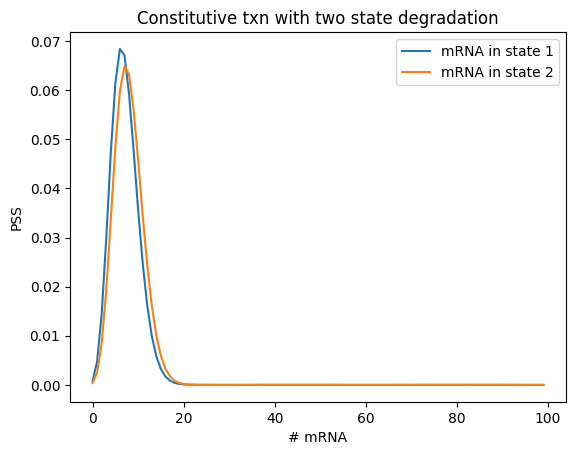

In [ ]:
plt.plot(PSS[:,0],label='mRNA in state 1')
plt.plot(PSS[:,1],label='mRNA in state 2')
plt.title('Constitutive txn with two state degradation')
plt.legend()
plt.xlabel('# mRNA')
plt.ylabel('PSS');

# Gillespie Stochastic Simulation Algorithm

In [11]:
# state vec X = {S_1, S_2, M}   where S_1,S_2 \in {0,1} and M \in N^0


updateRules = np.array([[0,0,1],     # (0,N) --> X(0,N+1)
                        [0,0,-1],    # (0,N) --> X(0,N-1)
                        [-1,1,0],    # (0,N) --> X(1,N)
                        [0,0,1],     # (1,N) --> X(1,N+1)
                        [0,0,-1],    # (1,N) --> X(1,N-1)
                        [1,-1,0]])   # (1,N) --> X(0,N)


def getPropensities(X,args):
  '''Returns state switching propensities given current state X and args, a dictionary of rates.
  '''

  P1 = args['k']*X[0]
  P2 = args['lambda1']*X[0]*X[2]
  P3 = args['r2']*X[0]
  P4 = args['k']*X[1]
  P5 = args['lambda2']*X[1]*X[2]
  P6 = args['r1']*X[1]

  return np.array([P1,P2,P3,P4,P5,P6])

def updateState(X,propensities,updateRules):
  '''Samples a reaction given propensities and updates the state vector X accordingly.
  '''
  propensities = propensities/propensities.sum()
  num = np.random.rand()
  sent = 0
  tot = 0.
  while tot < num:
    tot = tot + propensities[sent]
    sent = sent + 1
  j = sent-1

  j = np.random.choice(np.arange(len(propensities)),p=propensities)

  X = X + updateRules[j]
  return X

def sampleTau(propensities):
  '''Samples a time step given propensities.
  '''
  tau = np.random.exponential(1. / propensities.sum())
  # r1 = np.random.rand()
  # tau = (1/propensities.sum())*np.log(1/r1)
  return tau

def runRxn(initcond,T,args,updateRules):
  '''Given system initial condition (prob of being in State 1 and State 2) and args, simulate one statistically valid trajectory up to time T.
  '''
  # set initial condition
  num = np.random.rand()
  if num<=initcond[0]:
    X = np.array([1,0,0])
  else:
    X = np.array([0,1,0])

  t = 0
  while t<T:
    propensities = getPropensities(X,args)
    tau = sampleTau(propensities)
    X = updateState(X,propensities,updateRules)
    t = t + tau

  return(X)


def runRxns(initcond,T,args,updateRules,N):
  '''Simulate N trajectories up to time T.
  '''
  rxns = np.zeros((N,3))
  for n in range(N):
    X = runRxn(initcond,T,args,updateRules)
    rxns[n,:] = X

  return rxns





In [50]:
# Plot

def getBins(H):

  ub = H.max() + 6
  bins = np.arange(ub)-0.5
  hist,_ = np.histogram(H,bins,density=True)

  return bins,hist



def plotHist(H1,H2,PSS1,PSS2,xlim,PSS_state=[1,1],suptitle=''):
  P1  = PSS1
  P2  = PSS2

  fig, ax = plt.subplots(1,3,figsize=(18, 6))


  # Plot histograms
  color1 = 'royalblue'
  color2 = 'orange'
  # ax[0].hist(H1, bins=bins, color=color1, alpha=0.5, label='SSA final state', edgecolor='black', density=True)
  # ax[1].hist(H2, bins=bins, color=color2, alpha=0.5, label='SSA final state', edgecolor='black', density=True)
  bins1,hist1 = getBins(H1)
  bins2,hist2 = getBins(H2)
  ax[0].bar(bins1[:-1]+0.5,hist1*PSS_state[0],alpha=0.5,color=color1, label='SSA final state')
  ax[1].bar(bins2[:-1]+0.5,hist2*PSS_state[1],alpha=0.5,color=color2, label='SSA final state')

  # Plot curves
  ax[0].plot(x, P1, color=color1, label='GF solution', linewidth=3.5)
  ax[1].plot(x, P2, color=color2, label='GF solution', linewidth=3.5)
  ax[0].plot(x, P1, color='black', linestyle = '--')
  ax[1].plot(x, P2, color='black',  linestyle = '--')
  ax[0].set_title('State 1\n Marginal Distribution')
  ax[1].set_title('State 2\n Marginal Distribution')

  # plot NON marginal curves
  ax[2].plot(x,PSS1,color=color1, alpha = 0.5, linewidth=3.5, label = 'State 1')
  ax[2].plot(x,PSS2,color=color2, alpha = 0.5, linewidth=3.5, label = 'State 2')
  ax[2].plot(x,PSS1,color='black', linestyle = '--')
  ax[2].plot(x,PSS2,color='black', linestyle = '--')
  ax[2].set_title('GF solution')

  # Customizations
  for i in range(3):
    ax[i].grid(True, linestyle='--', alpha=0.4)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_visible(False)

    ax[i].set_xlabel('# mRNA', fontsize=14)
    ax[i].set_ylabel('Probability', fontsize=14)
    ax[i].tick_params(axis='both', labelsize=12)

    # Legend
    ax[i].legend(fontsize=12)
    ax[i].set_xlim(0,xlim)

  plt.suptitle(suptitle)
  plt.tight_layout()
  plt.show()

In [51]:
# PSS1 = PSS[:,0]
# PSS2 = PSS[:,1]
# plot_hist(H1,H2,PSS1,PSS2,xlim=35,bins=18,suptitle='')

6
[0.23076923 0.76923077]


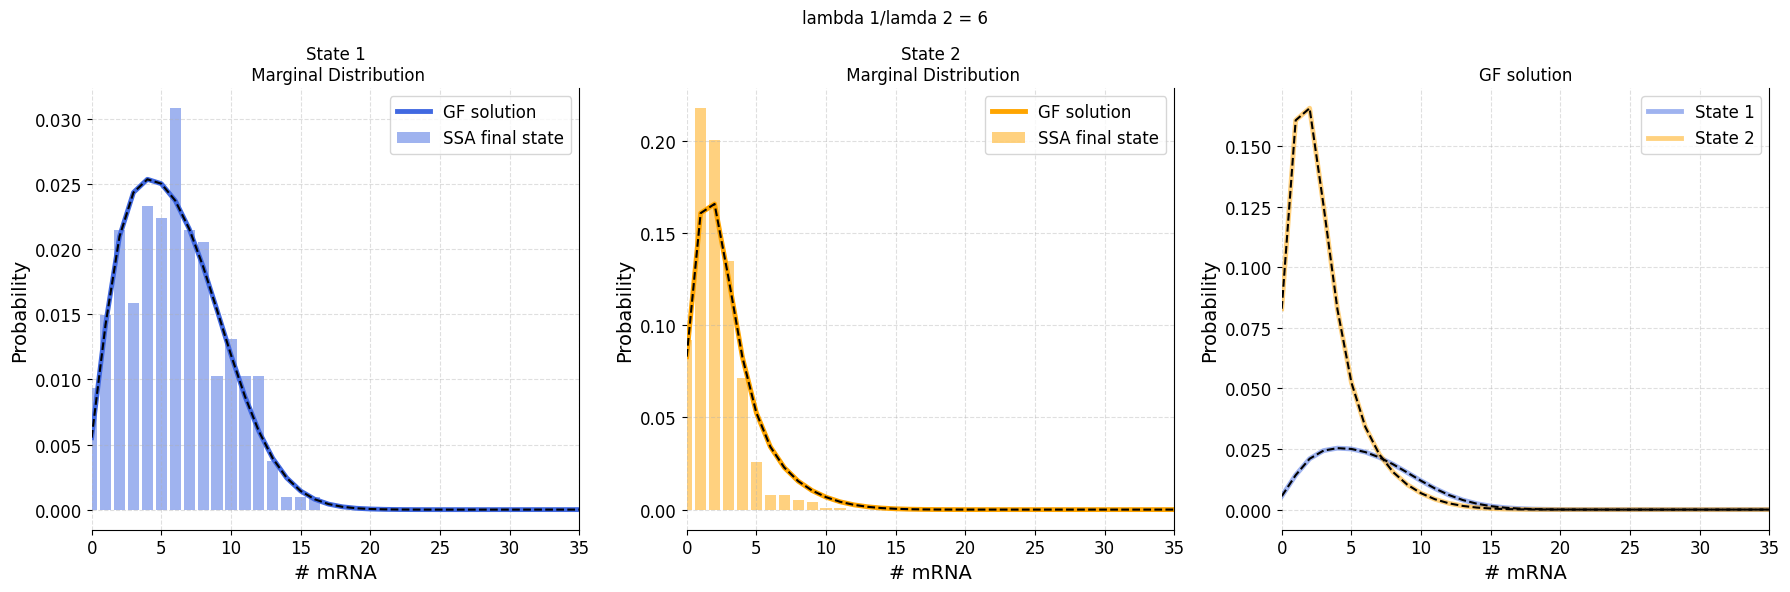

In [53]:
k = 10
lambda1 = 1
lambda2 = 1
r1 = .3
r2 = 1

for lam in [6]:
  print(lam)
  args_ = {'k' : k,
        'lambda1' : lambda1,
        'r1' : r1,
        'lambda2' : lam,
        'r2' : r2}
  rates = [args_[key] for key in ['k','lambda1','r1','lambda2','r2']]
  T = np.max([1/i for i in rates])*1e1

  y0 = get_H0(r1,r2)

  rxns = runRxns(y0,T,args_,updateRules,1000)
  PSS = getPSS(T,lim=10,args=args_)

  H1 = rxns[rxns[:,0]==1][:,2]
  H2 = rxns[rxns[:,1]==1][:,2]

  PSS1 = PSS[:,0]
  PSS2 = PSS[:,1]
  x = np.arange(len(PSS1))

  # get the steady state prob per gene state
  H = np.array([[-r2,r2],[r1,-r1]])
  PSS_state = np.dot(scipy.linalg.expm(T*H.T),y0)
  print(PSS_state)


  plotHist(H1,H2,PSS1,PSS2,xlim=35,PSS_state=PSS_state,suptitle=f'lambda 1/lamda 2 = {lam}')